In [ ]:
import numpy as np
import pandas as pd
from pandas.io.parsers import read_csv
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import PolynomialFeatures
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

Clase 0:  52.61601863465329
Clase 1:  47.38398136534671


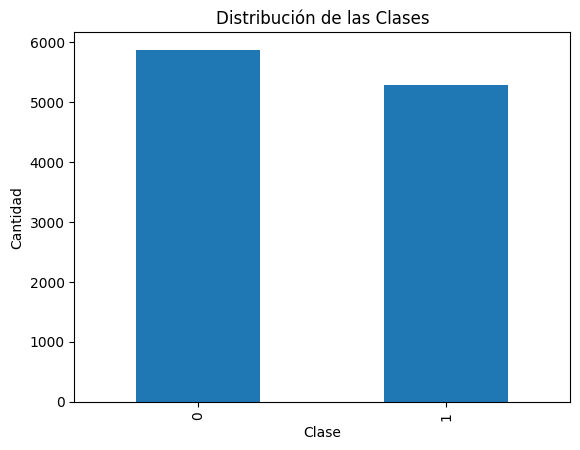

In [ ]:
def check_balance():
    df = pd.read_csv('bank.csv')

    df['deposit'] = pd.Categorical(df['deposit']).codes

    class_counts = df['deposit'].value_counts()
    class_percentage = class_counts / len(df) * 100

    print("Clase 0: ", class_percentage[0])
    print("Clase 1: ", class_percentage[1])
    
    class_counts.plot(kind='bar')
    plt.title("Distribución de las Clases")
    plt.xlabel("Clase")  
    plt.ylabel("Cantidad")  
    plt.show()

check_balance()


Como análisis preliminar, se ha estudidado la distribución de los datos para asegurarse de que no existen desequilibrios entre las clases. Los datos de una clase no predominan respecto a los de la otra.

Cabe señalar, que este estudio es aplicable a los otros algoritmos: redes neuronales y xgboost. 

Este estudio aporta un gran valor ya que nos permitirá abordar adecuadamente la interpretación de los resultados obtenidos para la precisión, el recall y F1.

In [ ]:
def dataprep():
    # Paso 1: Cargar los datos.
    df = pd.read_csv('bank.csv')

    # Paso 2: Definir las columnas categóricas.
    categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

    # Convertir la columna 'deposit' a binaria
    df['deposit'] = pd.Categorical(df['deposit']).codes

    # Paso 3: Codificar las columnas categóricas con get_dummies
    df = pd.get_dummies(df, columns=categorical_cols)

    # Paso 4: Dividir los datos en características (X) y etiquetas (y), y luego en conjuntos de entrenamiento y evaluación.
    X = df.drop('deposit', axis=1)
    y = df['deposit']

    X_train, X_valtest, y_train, y_valtest = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest, test_size=0.5, stratify=y_valtest, random_state=42)

    # Paso 5: Normalizar los datos de entrenamiento y aplicar la misma transformación a los datos de prueba.
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    return X_train, y_train, X_test, y_test, X_val, y_val 


In [ ]:
def sigmoide(z):
  """Realiza la función sigmoide de una Fw,b(x) = g(wx +b)"""
  return 1 / (1 + np.exp(-z))

In [ ]:
def calc_coste_regularizado(w, b, X, Y, lmda):
    """Calculo de la función de coste comparando la predicción con el valor de y."""
    g = sigmoide(np.matmul(X, w) + b)
    m = len(Y)
    J = np.sum((np.log(g).T * Y) + ((np.log(1-g).T * (1 - Y)))) / (-m) 
    reg = (lmda * np.sum(w[1:]**2) / (2*m))
    return J + reg

In [ ]:
def gradient_descent_regularizado(w, b, X, Y, lmda, alpha, numi):
  """Funcion que realiza del descenso de gradiente."""
  m = len(Y)
  J_historial = np.zeros(numi)

  for i in range(numi):
    g = sigmoide(np.matmul(X, w) + b)
    gd1 = (alpha / m) * np.matmul(X.T, g - Y)
    gd2 = (alpha / m) * (g - Y)

    reg = np.insert(lmda/m*w[1:], 0, values=[0])
    sumaregularizada = np.add(gd1,reg)
    reg2 = lmda *b / m
    sumregularizada2 = gd2#np.add(gd2, reg2)
    w = w - sumaregularizada
    b = b - sumregularizada2
    J_historial[i] = calc_coste_regularizado(w, b, X, Y, lmda)
  return w, J_historial

In [ ]:
def porcentaje_correctos(X, Y, w, b):
  """Devuelve el porcentaje correctos."""
  g = sigmoide(np.matmul(X, w) + b)
  return np.sum((g >= 0.5) == Y)/len(Y) * 100

In [ ]:
def obtener_predicciones(X, w, b):
  """Devuelve las predicciones necesarias para el cálculo de el Recall, la precisión y, consecuentemente, la medida F1."""
  g = sigmoide(np.matmul(X, w) + b)
  return (g >= 0.5).astype(int) 

In [ ]:
def aux_precision(precisionLista, lambdaa):
    graf = plt.figure()
    aux = graf.add_subplot(111)
    plt.plot(lambdaa, precisionLista)

    aux.set_xlabel('Lambda', fontsize=10)
    aux.set_ylabel('Precision', fontsize=10)
    plt.title("Porcentaje de aciertos en función de Lambda")
    plt.show()
    plt.close()


In [ ]:
def evolucion_coste (J_historial):
  plt.plot(J_historial)
  plt.xlabel('Número de iteraciones')
  plt.ylabel('Coste')
  plt.show()
  plt.close()

In [ ]:
def plot_precision_recall(precision_train, recall_train, precision_test, recall_test):
    plt.figure(figsize=(15, 6))

    # Gráfico para el conjunto de entrenamiento
    #plt.subplot(1, 2, 1)
    #plt.barh(['Precision', 'Recall'], [precision_train, recall_train], color=['#1f77b4', '#ff7f0e'])
    #plt.xlabel('Score')
    #plt.title('Train Data')

    # Gráfico para el conjunto de evaluación
    plt.subplot(1, 2, 2)
    plt.barh(['Precision', 'Recall'], [precision_test, recall_test], color=['#1f77b4', '#ff7f0e'])
    plt.xlabel('Score')
    plt.title('Test Data')

    plt.tight_layout() 
    plt.show()


El valor de alpha que mejores datos de validación obtiene es:  0.02631578947368421


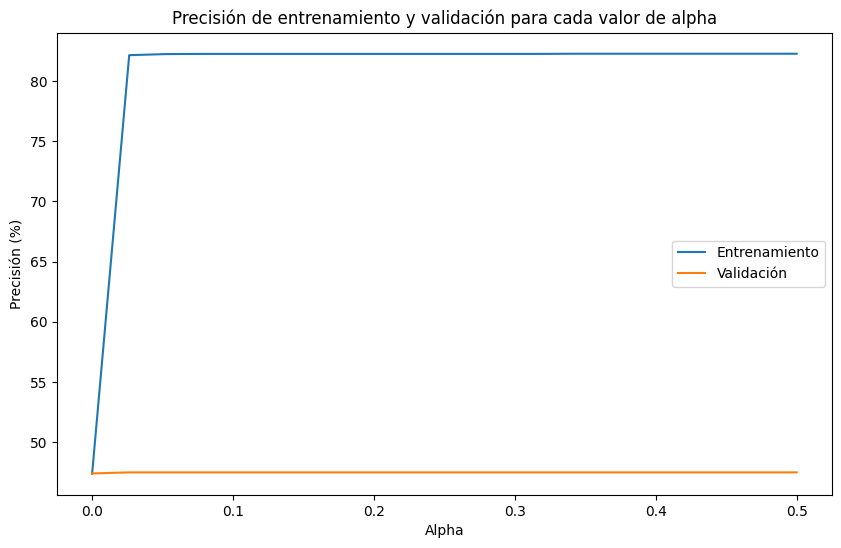

In [ ]:
def logistic_regressionalpha():
  """Modelo de regresión logística que calcula el mejor alpha (Tasa de aprendizaje)."""
  X_train, y_train, X_test, y_test, X_val, y_val  = dataprep()
  w = np.zeros(X_train.shape[1]) 
  b = 0
  alpha_values = np.linspace(0, 0.5, 20)
  i = 0
  numi = 1000
  train_precisions = []
  val_precisions = []
  J_historial = np.zeros(numi)
  best_alpha = 0
  best_val_precision = 0
  for alpha in alpha_values:
    w, J_historial = gradient_descent_regularizado(w, b, X_train, y_train,0, alpha, numi)
    precision = porcentaje_correctos(X_val, y_val, w, b)
    train = porcentaje_correctos(X_train, y_train, w, b)
    i+= 1
    train_precisions.append(train)
    val_precisions.append(precision)
    if precision > best_val_precision:
      best_val_precision = precision
      best_alpha = alpha
  
  print("El valor de alpha que mejores datos de validación obtiene es: ", best_alpha)
  plt.figure(figsize=(10, 6))
  plt.plot(alpha_values, train_precisions, label='Entrenamiento')
  plt.plot(alpha_values, val_precisions, label='Validación')
  plt.xlabel('Alpha')
  plt.ylabel('Precisión (%)')
  plt.title('Precisión de entrenamiento y validación para cada valor de alpha')
  plt.legend()
  plt.show()

logistic_regressionalpha()


La lambda que mejores datos de evaluación obtiene es:  0.0


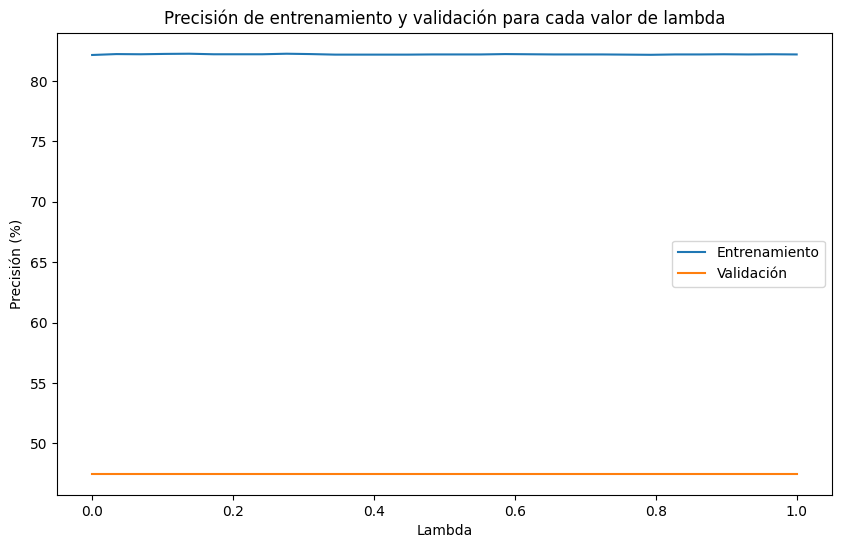

In [ ]:
def logistic_regression():
  """Modelo de regresión logística que calcula el mejor lambda (Parámetro de regularización)."""
  X_train, y_train, X_test, y_test, X_val, y_val  = dataprep()
  w = np.zeros(X_train.shape[1]) 
  b = 0
  lambdaa = np.linspace(0, 1, 30)
  precisionLista = np.zeros(shape=(len(lambdaa),))
  i = 0
  numi = 1000
  alpha = 0.02631578947368421
  train_precisions = []
  val_precisions = []
  J_historial = np.zeros(numi)
  best_lambda = 0
  best_val_precision = 0
  for lmda in lambdaa:
    w, J_historial = gradient_descent_regularizado(w, b, X_train, y_train, lmda, alpha, numi)
    precision = porcentaje_correctos(X_val,y_val, w, b)
    train = porcentaje_correctos(X_train, y_train, w, b)
    i+= 1
    train_precisions.append(train)
    val_precisions.append(precision)
    if precision > best_val_precision:
      best_val_precision = precision
      best_lambda = lmda
  
  print("La lambda que mejores datos de evaluación obtiene es: ", best_lambda)
  plt.figure(figsize=(10, 6))
  plt.plot(lambdaa, train_precisions, label='Entrenamiento')
  plt.plot(lambdaa, val_precisions, label='Validación')
  plt.xlabel('Lambda')
  plt.ylabel('Precisión (%)')
  plt.title('Precisión de entrenamiento y validación para cada valor de lambda')
  plt.legend()
  plt.show()

logistic_regression()



In [ ]:
def logistic_regression():
  """Modelo de regresión logística que calcula el mejor Lambda y alpha combinados."""
  X_train, y_train, X_test, y_test, X_val, y_val = dataprep()
  w = np.zeros(X_train.shape[1]) 
  b = 0
  lambda_values = np.linspace(0, 1, 30)
  alpha_values = np.linspace(0, 0.5, 20)
  best_lambda = 0
  best_alpha = 0
  best_val_precision = 0
  num_iterations = 1000
  train_precisions = []
  val_precisions = []

  for lmda in lambda_values:
    for alpha in alpha_values:
      w, _ = gradient_descent_regularizado(w, b, X_train, y_train, lmda, alpha, num_iterations)
      val_precision = porcentaje_correctos(X_val, y_val, w, b)
      train_precision = porcentaje_correctos(X_train, y_train, w, b)
      train_precisions.append(train_precision)
      val_precisions.append(val_precision)

      if val_precision > best_val_precision:
        best_val_precision = val_precision
        best_lambda = lmda
        best_alpha = alpha
  
  print("La mejor combinación de lambda y alpha:")
  print("Lambda:", best_lambda)
  print("Alpha:", best_alpha)

logistic_regression()


La mejor combinación de lambda y alpha:
Lambda: 0.0
Alpha: 0.02631578947368421


Por un lado, hemos calculado la mejor tasa de aprendizaje y el mejor parámetro de regularización separados.

Por otro lado, hemos calculado la mejor combinación de alpha y lambda. Usando ambos métodos, se observa que se obtienen los mismos resultados. Por lo tanto, seleccionaremos dichos alpha y lambda para el modelo final de regresión logística.

Porcentaje acertados de test:  82.31079265562025
Recall y precisión de test:  0.7844990548204159  y  0.8324974924774323
Medida F1 de test:  0.8077858880778589


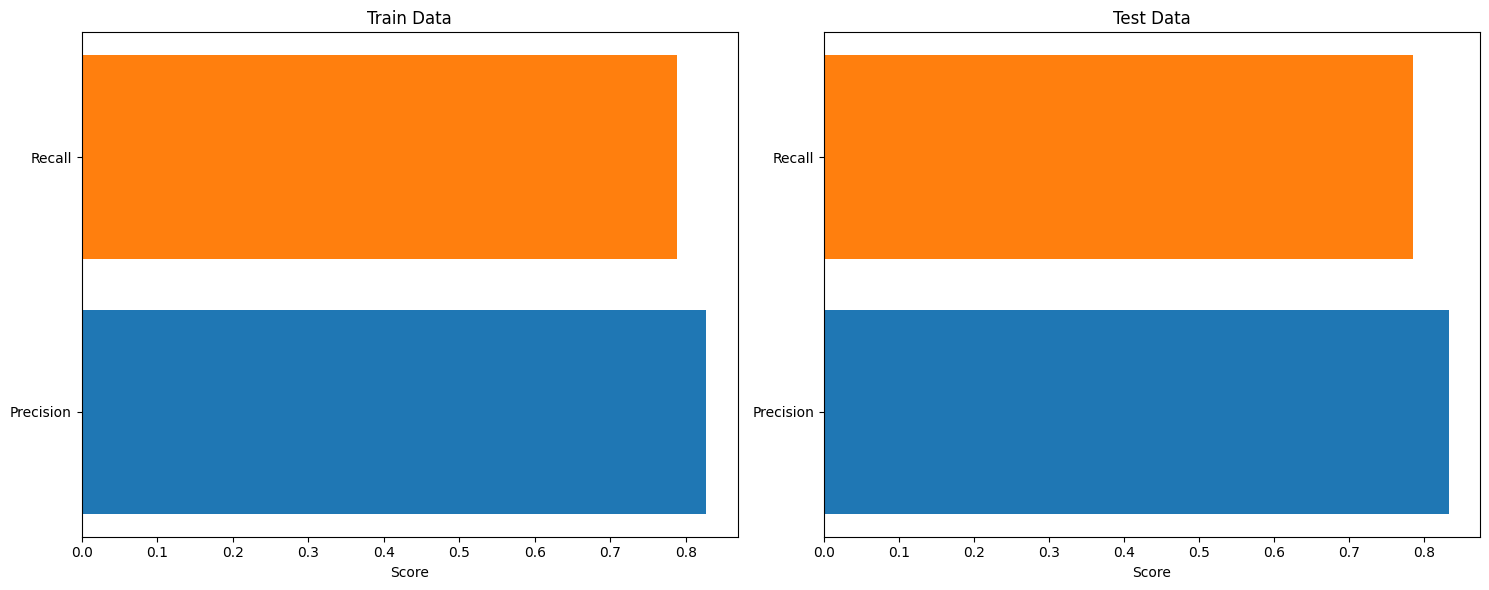

In [ ]:
"""
Calcula el modelo final con los mejores hiperparamétros obtenidos en el análisis anterior. Se obtienen y muestran medidas de rendimiento como el Recall, precisión, acierto (accuracy) y F1.
"""

X_train, y_train, X_test, y_test, X_val, y_val  = dataprep()
w = np.zeros(X_train.shape[1]) 
b = 0
numi = 1000
alpha = 0.02631578947368421
lmda = 0
w, J_historial = gradient_descent_regularizado(w, b, X_train, y_train, lmda, alpha, numi)

y_pred_train = obtener_predicciones(X_train, w, b)
y_pred_test = obtener_predicciones(X_test, w, b)


precision_train = precision_score(y_train, y_pred_train)
recall_train = recall_score(y_train, y_pred_train)

precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)

aciertos = porcentaje_correctos(X_test,y_test, w, b)
print("Porcentaje acertados de test: ", aciertos)
print("Recall y precisión de test: ", recall_test, " y ", precision_test)
f1_test = f1_score(y_test, y_pred_test)

print("Medida F1 de test: ", f1_test)
plot_precision_recall(precision_train, recall_train, precision_test, recall_test)



La precisión es igual a la división entre el número de positivos predecidos acertados y los positivos predecidos totales (positivos acertados y falsos positivos). Una precisión del 82% nos indica que de cada 100 campañas de marketing que espera vender, la regresión logística será capaz de predecir 82 con éxito. Es decir, de cada 100 campañas, vendería 82 depósitos y no vendería 18 campañas que espera vender.

Por otro lado, el recall es igual a la división entre 
el número de positivos acertados y el número de positivos reales. Un recall de 78% refleja que de cada 100 campañas de marketing que son exitosas (el cliente compra el depósito) acertaríamos el 78. Hay 22 campañas que son buenas y no acertamos.

Como tenemos mayor precisión, hay menos falsos positivos que falsos negativos. Un banco que hace una campaña de marketing con el objetivo de vender depósitos, priorizará la precisión frente a el recall. Esto es porque es más importante un falso positivo que un falso negativo. El motivo es que una mala precisión es perjudicial para la empresa porque si el banco espera vender más depósitos de lo que venderá realmente, esperará más beneficios de los que obtendrá en realidad (y esto puede manipular y engañar su situación financiera), mientras que si tiene un recall bajo, aunque la predicción ha sido mala, afectará de forma positiva a la empresa porque venderá más de lo que se espera. 

F1 se calcula como 2*(precisión *recall)/(precisión+recall).Esta métrica F1 tiene en cuenta tanto la precisión como el recall, lo que la hace especialmente útil en problemas donde es importante encontrar un equilibrio entre la minimización de los falsos positivos (precision) y la minimización de los falsos negativos (recall), como se ha mencionado anteriormente.

Un valor de F1 cercano a 1 indica un modelo con un buen equilibrio entre precision y recall, es decir, un modelo que logra identificar correctamente los casos positivos y minimiza tanto los falsos positivos como los falsos negativos. En nuestro caso, como tenemos un valor de 0.8077, se puede decir que existe un buen equilibrio entre la precisión el recall. Un valor de F1 cercano a 0 indica un rendimiento deficiente del modelo en términos de precision y recall.

Según los resultados obtenidos, se puede afirmar que el modelo es bastante preciso y capaz de detectar gran cantidad de resultados positvios. Su punto fuerte es la precisión y la accuracy.